In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shuyangli94/food-com-recipes-and-user-interactions")

# print("Path to dataset files:", path)

In [1]:
import pandas as pd
import gzip
import math
import random
from collections import defaultdict
import ast
import matplotlib.pyplot as plt

In [ ]:
#input files: PP_recipes.csv, RAW_interactions.csv  ingr_map.pkl           interactions_train.csv
#PP_users.csv    RAW_recipes.csv       interactions_test.csv  interactions_validation.csv

In [2]:
df_recipes = pd.read_csv('PP_recipes.csv')

In [3]:
df_recipes.columns

Index(['id', 'i', 'name_tokens', 'ingredient_tokens', 'steps_tokens',
       'techniques', 'calorie_level', 'ingredient_ids'],
      dtype='object')

In [4]:
df_interactions_train = pd.read_csv('interactions_train.csv')
df_interactions_test = pd.read_csv('interactions_test.csv')
df_interactions_validation = pd.read_csv('interactions_validation.csv')

In [5]:
df_interactions_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


collaborative filtering

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [ ]:
def Pearson(i1, i2):
    # Between two items
    iBar1 = itemAverages[i1]
    iBar2 = itemAverages[i2]
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += (ratingDict[(u,i1)] - iBar1)*(ratingDict[(u,i2)] - iBar2)
    for u in inter: #usersPerItem[i1]:
        denom1 += (ratingDict[(u,i1)] - iBar1)**2
    #for u in usersPerItem[i2]:
        denom2 += (ratingDict[(u,i2)] - iBar2)**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [16]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

In [17]:
for ind, d in df_interactions_train.iterrows():
    # print(d['u'], d['items'], d['ratings'])
    u,i,r = d['user_id'], d['recipe_id'], d['rating']
    reviewsPerUser[u].append((i,r))
    reviewsPerItem[i].append((u,r))

In [18]:
ratingMean = sum([d['rating'] for _,d in df_interactions_train.iterrows()]) / len(df_interactions_train)

In [19]:
ratingMean

4.574089892559891

In [20]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set)
itemNames = {}
ratingDict = {} # To retrieve a rating for a specific user/item pair

for ind, d in df_interactions_train.iterrows():
    # print(d['u'], d['items'], d['ratings'])
    u,i,r = d['user_id'], d['recipe_id'], d['rating']
    usersPerItem[i].add(u)
    itemsPerUser[u].add(i)
    ratingDict[(u,i)] = r

In [21]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [22]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)
    

In [ ]:
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d[0]
        if i2 == item: continue
        ratings.append(d[1] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean


In [ ]:
simPredictions = [predictRating(d['user_id'], d['recipe_id']) for _,d in df_interactions_train.iterrows()]

In [ ]:
labels = [d['rating'] for _, d in df_interactions_train.iterrows()]

In [28]:
train_mse = MSE(simPredictions, labels)

In [29]:
simPredictions = [predictRating(d['user_id'], d['recipe_id']) for _,d in df_interactions_validation.iterrows()]
labels = [d['rating'] for _, d in df_interactions_validation.iterrows()]
valid_mse = MSE(simPredictions, labels)


In [ ]:
##pearson

def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d[0]
        if i2 == item: continue
        ratings.append(d[1] - itemAverages[i2])
        similarities.append(Pearson(item,i2))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean


In [ ]:
###cosine

def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d[0]
        if i2 == item: continue
        ratings.append(d[1] - itemAverages[i2])
        similarities.append(Cosine(item,i2))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean


Latent Factor models

In [6]:
ratingsTrain = []
ratingsValid = []

for ind,d in df_interactions_train.iterrows():
    user, items, ratings = d['user_id'], d['recipe_id'], d['rating']
    ratingsTrain.append((user, items, ratings))

for ind,d in df_interactions_validation.iterrows():
    user, items, ratings = d['user_id'], d['recipe_id'], d['rating']
    ratingsValid.append((user, items, ratings))

In [7]:
trainRatings = [r[2] for r in ratingsTrain]
globalAverage = sum(trainRatings) * 1.0 / len(trainRatings)

In [8]:
alpha = globalAverage

In [9]:
# betaU = {}
# betaI = {}
# for u in reviewsPerUser:
#     betaU[u] = 0

# for b in reviewsPerItem:
#     betaI[b] = 0

In [10]:
# validMSE = 0
# for u,b,r in ratingsValid:
#   se = (r - globalAverage)**2
#   validMSE += se

# validMSE /= len(ratingsValid)

# print("Validation MSE (average only) = " + str(validMSE))

In [11]:
# def iterate(lamb):
#     newAlpha = 0
#     for u,b,r in ratingsTrain:
#         newAlpha += r - (betaU[u] + betaI[b])
#     alpha = newAlpha / len(ratingsTrain)
#     for u in reviewsPerUser:
#         newBetaU = 0
#         for b,r in reviewsPerUser[u]:
#             newBetaU += r - (alpha + betaI[b])
#         betaU[u] = newBetaU / (lamb + len(reviewsPerUser[u]))
#     for b in reviewsPerItem:
#         newBetaI = 0
#         for u,r in reviewsPerItem[b]:
#             newBetaI += r - (alpha + betaU[u])
#         betaI[b] = newBetaI / (lamb + len(reviewsPerItem[b]))
#     mse = 0
#     for u,b,r in ratingsTrain:
#         prediction = alpha + betaU[u] + betaI[b]
#         mse += (r - prediction)**2
#     regularizer = 0
#     for u in betaU:
#         regularizer += betaU[u]**2
#     for b in betaI:
#         regularizer += betaI[b]**2
#     mse /= len(ratingsTrain)
#     return mse, mse + lamb*regularizer

In [12]:
# mse,objective = iterate(1)
# newMSE,newObjective = iterate(1)
# iterations = 2

In [13]:
# while iterations < 100 or objective - newObjective > 0.0000001:
#     mse, objective = newMSE, newObjective
#     newMSE, newObjective = iterate(1)
#     iterations += 1
#     print("Objective after "
#         + str(iterations) + " iterations = " + str(newObjective))
#     print("MSE after "
#         + str(iterations) + " iterations = " + str(newMSE))

In [14]:
# validMSE = 0
# for u,b,r in ratingsValid:
#     bu = 0
#     bi = 0
#     if u in betaU:
#         bu = betaU[u]
#     if b in betaI:
#         bi = betaI[b]
#     prediction = alpha + bu + bi
#     validMSE += (r - prediction)**2

# validMSE /= len(ratingsValid)
# print("Validation MSE = " + str(validMSE))

Lambda: 0
Final Train MSE 0.5391790336432231
Final Val MSE 2.2143929910275615


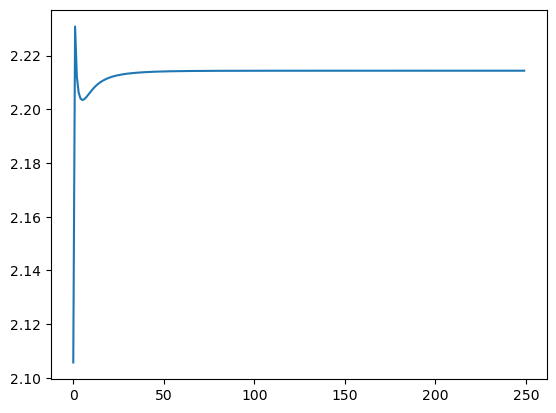

Lambda: 0.01
Final Train MSE 0.5391942822271747
Final Val MSE 1.9523432528019606


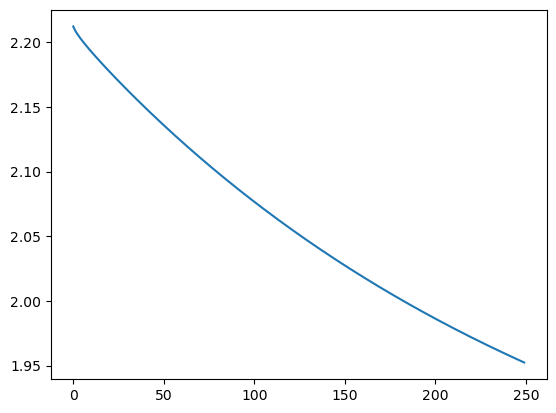

Lambda: 0.1
Final Train MSE 0.5402015668766875
Final Val MSE 1.7045614222970475


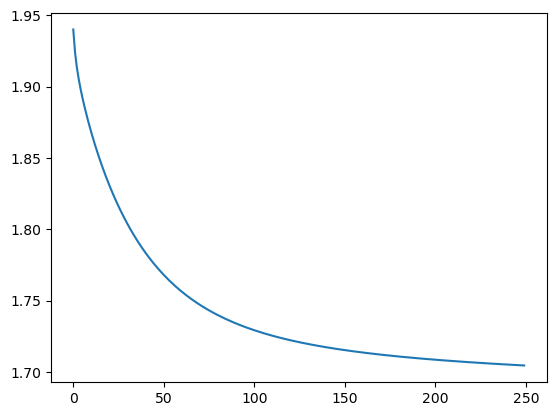

Lambda: 1
Final Train MSE 0.5724121803525128
Final Val MSE 1.6006190500232207


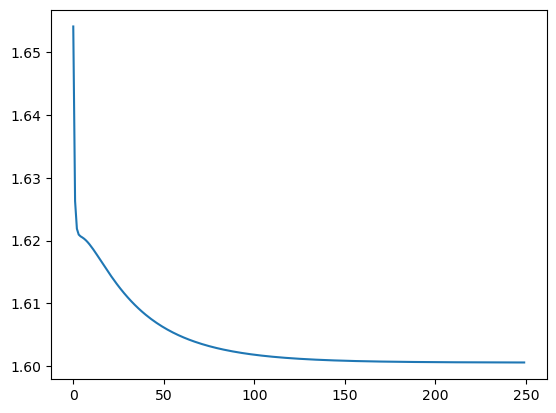

Lambda: 5
Final Train MSE 0.6622326221174843
Final Val MSE 1.5772453031719402


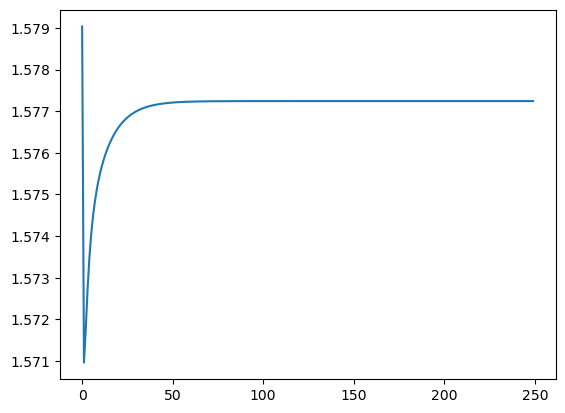

Lambda: 10
Final Train MSE 0.7085889194730405
Final Val MSE 1.5965440244401907


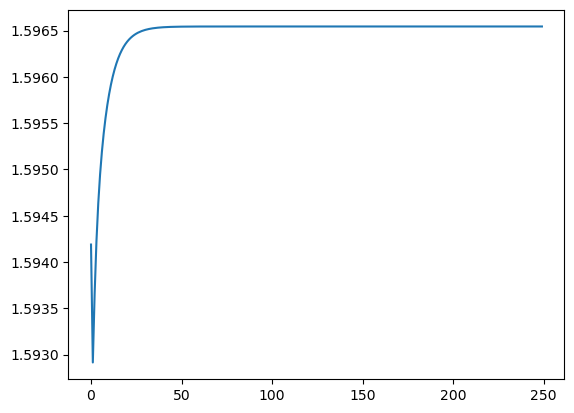

Lambda: 20
Final Train MSE 0.7511407454719183
Final Val MSE 1.6293354764174597


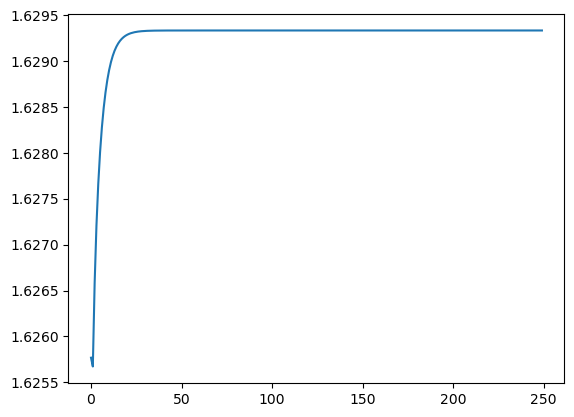

In [27]:
alpha = globalAverage
betaU = defaultdict(float)
betaI = defaultdict(float)
# gammaU = defaultdict(float)
# gammaI = defaultdict(float)
temp_betaU = defaultdict(float)
temp_betaI = defaultdict(float)
temp_gammaU = defaultdict(float)
temp_gammaI = defaultdict(float)

for u in reviewsPerUser.keys():
    betaU[u] = random.random()
    temp_betaU[u] = 0
for b in reviewsPerItem.keys():
    betaI[b] = random.random()
    temp_betaI[b] = 0
for lamb in [0, 0.01, 0.1, 1, 5, 10, 20]:
    train_mse = []
    valid_mse = []
    print('Lambda:',lamb)
    prev_mse = 0
    mse_train = 0
    mse=0
    epochs = 250
    while(epochs>0):
        prev_mse = mse
        
        for u in reviewsPerUser.keys():
            Iu = [i for i, _ in reviewsPerUser[u]]

            temp_betaU[u] = sum([r - alpha - betaI[b] for b, r in reviewsPerUser[u]]) / (lamb + len(reviewsPerUser[u]))
        for b in reviewsPerItem.keys():
            Ib = [i for i, _ in reviewsPerItem[b]]
            temp_betaI[b] = sum([r - alpha - betaU[u] for u, r in reviewsPerItem[b]]) / (lamb + len(reviewsPerItem[b]))

        betaU = temp_betaU
        betaI = temp_betaI
        alpha = sum([r - betaU[u] - betaI[b] for u, b, r in ratingsTrain]) / len(ratingsTrain)

        predictions = [(alpha + betaU[u] + betaI[b]) for u, b, _ in ratingsTrain]
        for pred in predictions:
            if pred < 0:
                pred = 0
            if pred > 5:
                pred = 5
        true_values = [r for _, _, r in ratingsTrain]
        mse_train = sum([(p-t)**2 for p, t in zip(predictions, true_values)])/len(predictions)
        cost = mse_train+lamb*(sum([betaU[u]**2 for u in reviewsPerUser.keys()])+sum([betaI[b]**2 for b in reviewsPerItem.keys()]))
        
            # print('Train MSE',mse_train)
        train_mse.append(mse_train)
        predictions = [(alpha + betaU[u] + betaI[b]) for u, b, _ in ratingsValid]
        for pred in predictions:
            if pred < 0:
                pred = 0
            if pred > 5:
                pred = 5
        true_values = [r for _, _, r in ratingsValid]
        mse = sum([(p-t)**2 for p, t in zip(predictions, true_values)])/len(predictions)
        valid_mse.append(mse)
            # print('Val MSE',mse)
            # print('-'*50)
        epochs -= 1
    print('Final Train MSE',mse_train)
    print('Final Val MSE',mse)
    # plt.plot(train_mse)
    plt.plot(valid_mse)
    plt.show()
    


In [42]:
df_interactions = pd.read_csv('PP_recipes.csv')

In [43]:
df_interactions.head()

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"
